**Example: Transfer-learning from M4 to Air Passengers**

In [ ]:
!pip install neuralforecast datasetsforecast utilsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.2/263.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 40.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from datasetsforecast.m4 import M4
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS
from neuralforecast.losses.pytorch import MAE


In [ ]:
# Preparing the M4 monthly dataset with a datetime index for forecasting.
Y_df, _, _ = M4.load(directory="./", group="Monthly")
Y_df["ds"] = Y_df.groupby("unique_id")["ds"].transform(
  lambda x: pd.date_range(start="1970-01-01", periods=len(x), freq="MS")
)
Y_df.head()

91.7MiB [00:01, 57.7MiB/s]
ERROR:datasetsforecast.utils:ERROR, something went wrong downloading data
7.94MiB [00:00, 48.9MiB/s]
ERROR:datasetsforecast.utils:ERROR, something went wrong downloading data
4.34MiB [00:00, 78.1MiB/s]                 
ERROR:datasetsforecast.utils:ERROR, something went wrong downloading data
100%|██████████| 3.56M/3.56M [00:00<00:00, 38.8MiB/s]


,unique_id,ds,y
0,M1,1970-01-01,8000.0
1,M1,1970-02-01,8350.0
2,M1,1970-03-01,8570.0
3,M1,1970-04-01,7700.0
4,M1,1970-05-01,7080.0


A pretrained NHITS model is used as a foundation model to transfer learned patterns from the M4 dataset to a new time series.


In [ ]:
# Predicting the next 12 months
horizon = 12
stacks = 3

# NHITS model configuration for foundation pre-training
models = [
    NHITS(
        input_size=5 * horizon,
        h=horizon,

        max_steps=500,  # Reduced for computational feasibility in Colab
        stack_types=stacks * ["identity"],
        n_blocks=stacks * [1],
        mlp_units=[[256, 256] for _ in range(stacks)],
        n_pool_kernel_size=stacks * [1],
        batch_size=32,
        scaler_type="standard",
        n_freq_downsample=[12, 4, 1],
    )
]

nf = NeuralForecast(models=models, freq="M")

INFO:lightning_fabric.utilities.seed:Seed set to 1


In [ ]:
nf.fit(df=Y_df)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ blocks       │ ModuleList    │  689 K │ train │     0 │
└───┴──────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 689 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 689 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 34                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


In [ ]:
# Loading and format the AirPassengers dataset for NeuralForecast
air_passengers_df = pd.read_csv("AirPassengers.csv")
air_passengers_df.columns = ["ds", "y"]
air_passengers_df["ds"] = pd.to_datetime(air_passengers_df["ds"])
air_passengers_df["unique_id"] = "AirPassengers"

air_passengers_df = air_passengers_df[["unique_id", "ds", "y"]]
air_passengers_df.head()

# Applying the pretrained NHITS model to forecast the AirPassengers time series
transfer_preds = nf.predict(df=air_passengers_df)

/usr/local/lib/python3.12/dist-packages/utilsforecast/processing.py:378: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.12/dist-packages/utilsforecast/processing.py:434: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Output()

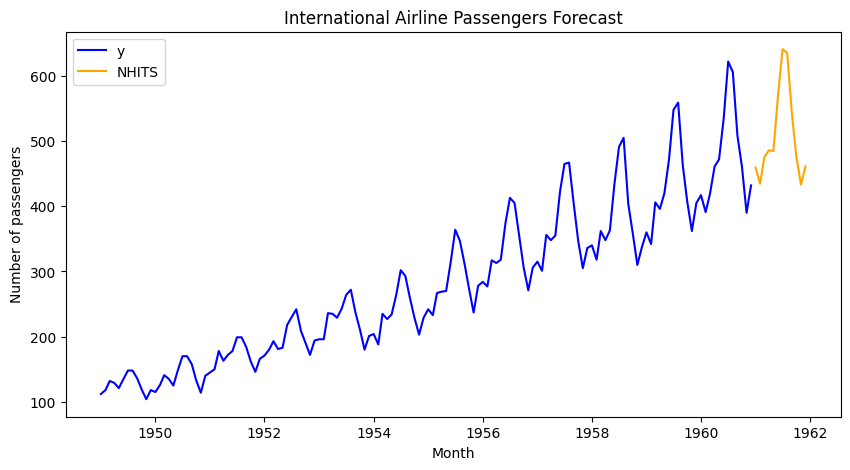

In [ ]:
import matplotlib.pyplot as plt

# Actual values
plt.figure(figsize=(10, 5))
plt.plot(
    air_passengers_df["ds"],
    air_passengers_df["y"],
    label="y",
    color="blue"
)

# Forecast values
plt.plot(
    transfer_preds["ds"],
    transfer_preds["NHITS"],
    label="NHITS",
    color="orange"
)

plt.title("International Airline Passengers Forecast")
plt.xlabel("Month")
plt.ylabel("Number of passengers")
plt.legend()
plt.show()


The pretrained NHITS model captures the main trend and seasonality of the AirPassengers dataset. Despite not being trained on this series, the forecasts align well with historical patterns, demonstrating effective transfer learning from the M4 dataset.

**Example: electricity price forecasting**

Evaluate foundation models **(TimeGPT and Moirai)** on hourly electricity prices,
incorporating exogenous variables (load and wind generation) and calendar effects(hourly prices **(y)**, day-ahead load forecasts **(Exogenous1)**, wind generation **(Exogenous2)**, and one-hot encoded day-of-week indicators).

In [ ]:
import pandas as pd

df = pd.read_csv("/content/electricity_short.csv", parse_dates=["ds"])
df.head()

,unique_id,ds,y,Exogenous1,Exogenous2,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,NP,2018-10-15 00:00:00,2.17,34078.0,1791.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NP,2018-10-15 01:00:00,4.03,33469.0,1489.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NP,2018-10-15 02:00:00,4.88,33313.0,1233.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NP,2018-10-15 03:00:00,10.47,33535.0,1035.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NP,2018-10-15 04:00:00,17.51,34267.0,854.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
!pip install nixtla

In [ ]:
from nixtla import NixtlaClient

# I use the Nixtla API with using the link via book.
# The API key is stored securely using Colab secrets.

In [ ]:
from google.colab import userdata

# Retrieve the API key from Colab secrets
NIXTLA_API_KEY = userdata.get('NIXTLA_API_KEY')

In [ ]:
from nixtla import NixtlaClient

# NixtlaClient with the NIXTLA_API_KEY retrieved from Colab secrets
nixtla_client = NixtlaClient(api_key=NIXTLA_API_KEY)
preds_df = nixtla_client.forecast(df=df, h=24, level=[80, 90])
preds_df.head()

,unique_id,ds,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,NP,2018-12-24 00:00:00,51.033173,52.283886,52.534220,49.782460,49.532124
1,NP,2018-12-24 01:00:00,50.122090,51.375870,51.602417,48.868310,48.641760
2,NP,2018-12-24 02:00:00,49.715855,51.224205,51.401196,48.207504,48.030514
3,NP,2018-12-24 03:00:00,49.131313,50.419310,50.545930,47.843315,47.716698
4,NP,2018-12-24 04:00:00,49.641170,50.677710,50.772137,48.604630,48.510204


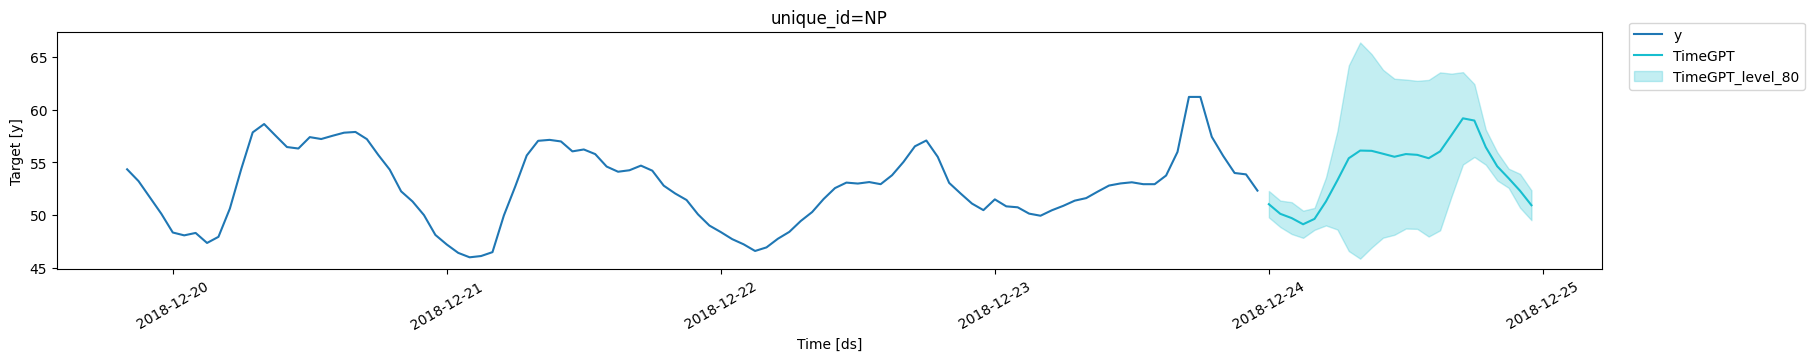

In [ ]:
from utilsforecast.plotting import plot_series

plot_series(
    df,
    preds_df,
    max_insample_length=100,
    level=[80]
)

# The TimeGPT zero-shot forecast reflects the recent electricity price dynamics and preserves the overall level and short-term fluctuations.
# The 80% prediction interval reflects the uncertainty in future prices.

In [ ]:
cv_preds_df = nixtla_client.cross_validation(df=df, h=24, n_windows=3)
cv_preds_df.head()

#The cross-validation results show that TimeGPT predictions are close to the observed values.

,unique_id,ds,cutoff,y,TimeGPT
0,NP,2018-12-21 00:00:00,2018-12-20 23:00:00,47.21,47.608387
1,NP,2018-12-21 01:00:00,2018-12-20 23:00:00,46.42,47.164246
2,NP,2018-12-21 02:00:00,2018-12-20 23:00:00,46.00,46.522350
3,NP,2018-12-21 03:00:00,2018-12-20 23:00:00,46.12,47.209810
4,NP,2018-12-21 04:00:00,2018-12-20 23:00:00,46.49,47.953070


In [ ]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae

evaluation = evaluate(cv_preds_df, models=["TimeGPT"], metrics=[mae])
methods = ['TimeGPT']
evaluation_transformed = pd.DataFrame({
  'Method': methods,
  'MAE': evaluation[evaluation['metric'] == 'mae'][methods].iloc[0].values,
})
evaluation_transformed

#The cross-validation results show that without fine-tuning, it achieves an average MAE of 2.54 which is reasonable forecast

,Method,MAE
0,TimeGPT,2.540898


In [ ]:
cv_finetune_preds_df = nixtla_client.cross_validation(
  df=df, h=24, n_windows=3, finetune_steps=15, finetune_loss="mae"
)
evaluation = evaluate(cv_finetune_preds_df, models=["TimeGPT"], metrics=[mae])
evaluation = evaluation.rename(columns={"TimeGPT": "TimeGPT-finetuned"})
methods = ['TimeGPT-finetuned']
evaluation_transformed = pd.DataFrame({
  'Method': methods,
  'MAE': evaluation[evaluation['metric'] == 'mae'][methods].iloc[0].values,
})
evaluation_transformed

# After fine-tuning, the MAE slightly decreases from 2.54 to 2.51.

,Method,MAE
0,TimeGPT-finetuned,2.511443


In [ ]:
future_ex_vars_df = pd.read_csv(
  "/content/electricity_future_vars.csv", parse_dates=["ds"]
)
future_ex_vars_df.head()

# Future exogenous variables used as additional inputs for the forecast.

,unique_id,ds,Exogenous1,Exogenous2,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,NP,2018-12-24 00:00:00,49119.0,461.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NP,2018-12-24 01:00:00,48115.0,484.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NP,2018-12-24 02:00:00,47727.0,497.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NP,2018-12-24 03:00:00,47673.0,509.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NP,2018-12-24 04:00:00,47848.0,510.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
exog_preds_df = nixtla_client.forecast(
  df=df, X_df=future_ex_vars_df, h=24, level=[80, 90]
)
exog_preds_df = exog_preds_df.rename(columns={"TimeGPT": "TimeGPT-exog"})
exog_preds_df.head()
# It slightly modifies the forecast, suggesting that additional information can influence the predicted price levels.

,unique_id,ds,TimeGPT-exog,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,NP,2018-12-24 00:00:00,50.981987,53.941290,54.131767,48.022682,47.832207
1,NP,2018-12-24 01:00:00,51.055580,54.528404,54.659187,47.582756,47.451973
2,NP,2018-12-24 02:00:00,50.088425,53.066750,53.088837,47.110100,47.088013
3,NP,2018-12-24 03:00:00,49.411022,51.676746,51.688156,47.145298,47.133890
4,NP,2018-12-24 04:00:00,49.270676,50.697887,50.820385,47.843464,47.720966


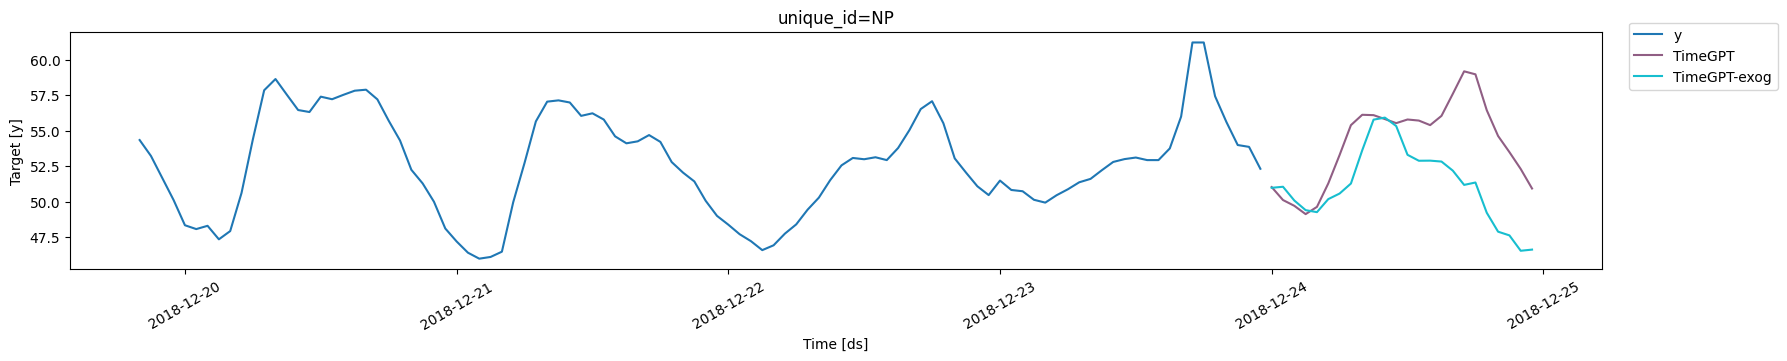

In [ ]:
# The plotting code in book caused an error because plot_series does not support xlabel and ylabel, so i used matplotlib  before or without that label, the graps are correct and same with the book.
fcst_df = pd.merge(
    preds_df[["unique_id", "ds", "TimeGPT"]],
    exog_preds_df[["unique_id", "ds", "TimeGPT-exog"]],
    on=["unique_id", "ds"],
    how="inner",
)

from utilsforecast.plotting import plot_series

plot_series(
    df,
    fcst_df,
    max_insample_length=100
)

# It is seen that by using exogenous features, the model can model variations in the data that were not previously captured.

In [ ]:
# Convert data to GluonTS format and create train–test splits.
!pip install gluonts

from gluonts.dataset.pandas import PandasDataset

full_df = pd.concat([df, future_ex_vars_df], axis=0)
full_df = full_df.set_index("ds")
ds = PandasDataset.from_long_dataframe(
  full_df,
  target="y",
  item_id="unique_id",
  feat_dynamic_real=[
    "Exogenous1",
    "Exogenous2",
    "day_0",
    "day_1",
    "day_2",
    "day_3",
    "day_4",
    "day_5",
    "day_6",
  ],
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.7 MB/s eta 0:00:00


In [ ]:
from gluonts.dataset.split import split

train, test_template = split(ds, offset=-24)
test_data = test_template.generate_instances(
  prediction_length=24, windows=1, distance=24,
)